# Bitcoin Recurrent Neural Network
### Justin Marlor & Habit Blunk
##### *Colorado State University*

This is our notebook that automatically copies data from [this dataset hosted on Kaggle](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data), then throws it into various neural networks and predicts the price of Bitcoin.

This dataset is centered around the price of Bitcoin. The original dataset included 1 minute interval measures of the 'High', 'Low', 'Open', 'Close', 'Volume', as well as the UNIX timestamp and a column 'datetime'. The original dataset was over contained over 7,000,000 rows. 
We used a recurrent neural network (RNN), as well as a long short-term memory (LSTM) model to make price predictions for the near future. The main motivation to use this model comes from the RNN's ability to effectively do time-series forecasting since it retains sequential history and can handle long-term trends better than other models.

### Methodology
To reduce noise and redundancy, the data was aggregated by selecting only rows recorded at 23:59 each day, creating a daily time series. The features Open, High, and Low were dropped, retaining only the Close price and Volume for prediction. Before training, the data was standardized using StandardScaler to improve model convergence and stability. Sequences of 60 timesteps (approximately two months of data) were constructed as input features, and the Close price at the next timestep served as the prediction target. These sequences were wrapped in a custom TimeSeriesDataset class and split into training and validation sets using a 95/5 ratio. We trained and evaluated two models: a basic Recurrent Neural Network (RNN) and a Long Short-Term Memory (LSTM) network. Both used 64 hidden units and a single recurrent layer. The models were trained over a range of epochs [2, 4, 8, 16, 32, 64, 128], and the model achieving the lowest Mean Squared Error (MSE) on the training set was saved. Finally, the best-performing model was used to predict future Close prices for 10 days into the future. Since the model output was in normalized form, predictions were denormalized using the inverse transform of the original scaler to obtain interpretable price values.

To run it:

1. Run the script located in this repository at `./env-script`. This will set up your virtual environment. 

    `./env-script`
    ```bash
    #!/bin/bash
    [ ! -d "venv" ] && python -m venv venv
    source "venv/bin/activate" && pip install -r "dependencies.txt" && python -m ipykernel install --user --name=venv && jupyter notebook
    ```
   `./add-run-kaggle-bitcoin` 
   ```bash
    #!/bin/bash
  
    [ ! -d "kaggle-bitcoin" ] && git clone https://github.com://chabitblunk/kaggle-bitcoin.git
    cd kaggle-bitcoin || exit
    poetry install && poetry run python kaggle_bitcoin/kaggle_update_bitcoin.py 
   ```

    `./dependencies.txt`
    ```
      anyio==4.4.0
      argon2-cffi==23.1.0
      argon2-cffi-bindings==21.2.0
      arrow==1.3.0
      asttokens==2.4.1
      async-lru==2.0.4
      attrs==24.2.0
      babel==2.16.0
      beautifulsoup4==4.12.3
      bleach==6.1.0
      build==1.2.2.post1
      CacheControl==0.14.2
      certifi==2024.8.30
      cffi==1.17.1
      charset-normalizer==3.3.2
      cleo==2.1.0
      comm==0.2.2
      contourpy==1.3.1
      crashtest==0.4.1
      cryptography==44.0.2
      cycler==0.12.1
      debugpy==1.8.5
      decorator==5.1.1
      defusedxml==0.7.1
      distlib==0.3.9
      dulwich==0.22.8
      executing==2.1.0
      fastjsonschema==2.20.0
      filelock==3.18.0
      findpython==0.6.3
      fonttools==4.56.0
      fqdn==1.5.1
      fsspec==2025.3.2
      h11==0.14.0
      httpcore==1.0.5
      httpx==0.27.2
      idna==3.8
      installer==0.7.0
      ipykernel==6.29.5
      ipython==8.27.0
      ipython_pygments_lexers==1.1.1
      ipywidgets==8.1.5
      isoduration==20.11.0
      jaraco.classes==3.4.0
      jaraco.context==6.0.1
      jaraco.functools==4.1.0
      jedi==0.19.1
      jeepney==0.9.0
      Jinja2==3.1.4
      joblib==1.4.2
      json5==0.9.25
      jsonpointer==3.0.0
      jsonschema==4.23.0
      jsonschema-specifications==2023.12.1
      jupyter==1.1.1
      jupyter-console==6.6.3
      jupyter-events==0.10.0
      jupyter-lsp==2.2.5
      jupyter_client==8.6.2
      jupyter_core==5.7.2
      jupyter_server==2.14.2
      jupyter_server_terminals==0.5.3
      jupyterlab==4.3.6
      jupyterlab_pygments==0.3.0
      jupyterlab_server==2.27.3
      jupyterlab_widgets==3.0.13
      kaggle==1.6.17
      -e git+https://github.com://chabitblunk/kaggle-bitcoin.git@382e5fe336c5cb213f32a62cf838d453498b8781#egg=kaggle_bitcoin
      keyring==25.6.0
      kiwisolver==1.4.8
      MarkupSafe==2.1.5
      matplotlib==3.10.1
      matplotlib-inline==0.1.7
      mistune==3.0.2
      more-itertools==10.6.0
      mpmath==1.3.0
      msgpack==1.1.0
      nbclient==0.10.0
      nbconvert==7.16.4
      nbformat==5.10.4
      nest-asyncio==1.6.0
      networkx==3.4.2
      notebook==7.3.3
      notebook_shim==0.2.4
      numpy==2.1.1
      nvidia-cublas-cu12==12.4.5.8
      nvidia-cuda-cupti-cu12==12.4.127
      nvidia-cuda-nvrtc-cu12==12.4.127
      nvidia-cuda-runtime-cu12==12.4.127
      nvidia-cudnn-cu12==9.1.0.70
      nvidia-cufft-cu12==11.2.1.3
      nvidia-curand-cu12==10.3.5.147
      nvidia-cusolver-cu12==11.6.1.9
      nvidia-cusparse-cu12==12.3.1.170
      nvidia-cusparselt-cu12==0.6.2
      nvidia-nccl-cu12==2.21.5
      nvidia-nvjitlink-cu12==12.4.127
      nvidia-nvtx-cu12==12.4.127
      overrides==7.7.0
      packaging==24.1
      pandas==2.2.3
      pandocfilters==1.5.1
      parso==0.8.4
      pbs-installer==2025.4.9
      pexpect==4.9.0
      pillow==11.2.1
      pkginfo==1.12.1.2
      platformdirs==4.3.2
      poetry==2.1.0
      poetry-core==2.1.0
      prometheus_client==0.20.0
      prompt_toolkit==3.0.47
      protobuf==6.30.2
      psutil==6.0.0
      ptyprocess==0.7.0
      pure_eval==0.2.3
      pycparser==2.22
      Pygments==2.18.0
      pyparsing==3.2.3
      pyproject_hooks==1.2.0
      python-dateutil==2.9.0.post0
      python-json-logger==2.0.7
      python-slugify==8.0.4
      pytz==2024.2
      PyYAML==6.0.2
      pyzmq==26.2.0
      RapidFuzz==3.13.0
      referencing==0.35.1
      requests==2.32.3
      requests-toolbelt==1.0.0
      rfc3339-validator==0.1.4
      rfc3986-validator==0.1.1
      rpds-py==0.20.0
      scikit-learn==1.6.1
      scipy==1.15.2
      SecretStorage==3.3.3
      Send2Trash==1.8.3
      setuptools==74.1.2
      shellingham==1.5.4
      six==1.16.0
      sniffio==1.3.1
      soupsieve==2.6
      stack-data==0.6.3
      sympy==1.13.1
      terminado==0.18.1
      text-unidecode==1.3
      threadpoolctl==3.6.0
      tinycss2==1.3.0
      tomlkit==0.13.2
      torch==2.6.0
      tornado==6.4.1
      tqdm==4.66.5
      traitlets==5.14.3
      triton==3.2.0
      trove-classifiers==2025.4.11.15
      types-python-dateutil==2.9.0.20240906
      typing_extensions==4.13.0
      tzdata==2024.1
      uri-template==1.3.0
      urllib3==2.2.3
      virtualenv==20.30.0
      wcwidth==0.2.13
      webcolors==24.8.0
      webencodings==0.5.1
      websocket-client==1.8.0
      widgetsnbextension==4.0.13
      zstandard==0.23.0
          
    ``` 
2. Run `source ./venv/bin/activate`. This will put you in the virtual environment we have set up, so this notebook can be run on any machine so long as it has Python 3.x and can install the dependencies at `./dependencies.txt`.
3. Paste this into `~/.config/kaggle/kaggle.json`:
    ```json
    {
      "username": "justinmarlor",
      "key": "b98017f9291bfa83686f6c6780d38e04"
    }
    ```
4. Execute each cell in sequence.

#### Cell 1: Imports and TimeSeries class

In [1]:
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
from torch.nn import RNN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, tensor, seq_length, target_idx):
        self.tensor = tensor
        self.seq_length = seq_length
        self.target_idx = target_idx

    def __len__(self):
        return len(self.tensor) - self.seq_length

    def __getitem__(self, idx):
        seq = self.tensor[idx:idx + self.seq_length]
        target = self.tensor[idx + self.seq_length, self.target_idx]
        return seq, target 

#### Cell 2: Grabbing and preprocessing data

In [2]:
result = subprocess.run(['bash', './add-run-kaggle-bitcoin'], capture_output=True,text=True)

print(result.stdout)
print(result.stderr)

if result.returncode == 0:
    df = pd.read_csv("kaggle-bitcoin/upload/btcusd_1-min_data.csv", dtype={"Volume": float}, low_memory=False)
    df['datetime'] = pd.to_datetime(df['Timestamp'].astype('Int64'), unit='s', errors='coerce')
    display(df)

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: kaggle-bitcoin (0.1.0)
Current time (UTC): 2025-05-08 05:33:06.275271+00:00
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
Checking for missing data...
Last data point in dataset: 2025-05-08 00:46:00+00:00 (Unix: 1746665160)
Current time (minus buffer): 2025-05-08 05:23:12.025081+00:00 (Unix: 1746681792)
Gap of 16632 seconds detected.
Missing data detected.
Fetching data from 2025-05-08 00:46:00+00:00 to 2025-05-08 05:23:12+00:00
Fetching chunk 1/1: 2025-05-08 00:46:00+00:00 to 2025-05-08 05:23:12+00:00
  - Retrieved 1000 data points
Total new data points: 1000
Combined dataset size before deduplication: 7020726
Final dataset size after deduplication: 7020003
Updated dataset saved to upload/btcusd_1-min_data.csv




,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:05:00
...,...,...,...,...,...,...,...
7019998,1.746682e+09,98862.00,98870.00,98860.00,98870.00,0.240999,2025-05-08 05:19:00
7019999,1.746682e+09,98862.00,98931.00,98862.00,98931.00,0.225280,2025-05-08 05:20:00
7020000,1.746682e+09,98923.00,98924.00,98852.00,98853.00,0.178397,2025-05-08 05:21:00
7020001,1.746682e+09,98852.00,98857.00,98852.00,98857.00,0.003078,2025-05-08 05:22:00


#### Reducing the data to 1 Close value per day

In [3]:
df = df[df['datetime'].dt.time == pd.to_datetime('23:59').time()]
df

,Timestamp,Open,High,Low,Close,Volume,datetime
838,1.325462e+09,4.84,4.84,4.84,4.84,0.000000,2012-01-01 23:59:00
2278,1.325549e+09,5.00,5.00,5.00,5.00,0.000000,2012-01-02 23:59:00
3718,1.325635e+09,5.29,5.29,5.29,5.29,0.000000,2012-01-03 23:59:00
5158,1.325722e+09,5.57,5.57,5.57,5.57,0.000000,2012-01-04 23:59:00
6598,1.325808e+09,6.42,6.42,6.42,6.42,0.000000,2012-01-05 23:59:00
...,...,...,...,...,...,...,...
7013918,1.746317e+09,95919.00,95919.00,95916.00,95916.00,0.003158,2025-05-03 23:59:00
7015358,1.746403e+09,94324.00,94335.00,94316.00,94316.00,1.630224,2025-05-04 23:59:00
7016798,1.746490e+09,94754.00,94754.00,94725.00,94725.00,0.043522,2025-05-05 23:59:00
7018238,1.746576e+09,96794.00,96835.00,96794.00,96814.00,0.044224,2025-05-06 23:59:00


#### PCA
We use PCA as a strategy to discover noise in our dataset, allowing us to remove unnecessary features in our dataset. This PCA shows us that there is a very similar correlation value between each of the 'open', 'high', 'low', 'close' columns. The trading volume is the other feature that has a strong correlation to the price of bitcoin. We will proceed to train the models using the two features, Close and Volume.

In [4]:
X = df
X = df.drop(columns=['Timestamp', 'datetime'])

# Standardizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=X.columns)
print(loadings)

             PC1       PC2
Open    0.499395  0.024587
High    0.499395  0.024656
Low     0.499396  0.024504
Close   0.499396  0.024569
Volume -0.049158  0.998791


In [5]:
# Removal of Redundant Columns
df = df.drop(columns=['Open','High','Low'])
df

,Timestamp,Close,Volume,datetime
838,1.325462e+09,4.84,0.000000,2012-01-01 23:59:00
2278,1.325549e+09,5.00,0.000000,2012-01-02 23:59:00
3718,1.325635e+09,5.29,0.000000,2012-01-03 23:59:00
5158,1.325722e+09,5.57,0.000000,2012-01-04 23:59:00
6598,1.325808e+09,6.42,0.000000,2012-01-05 23:59:00
...,...,...,...,...
7013918,1.746317e+09,95916.00,0.003158,2025-05-03 23:59:00
7015358,1.746403e+09,94316.00,1.630224,2025-05-04 23:59:00
7016798,1.746490e+09,94725.00,0.043522,2025-05-05 23:59:00
7018238,1.746576e+09,96814.00,0.044224,2025-05-06 23:59:00


#### Cell 3: plotting current dataset

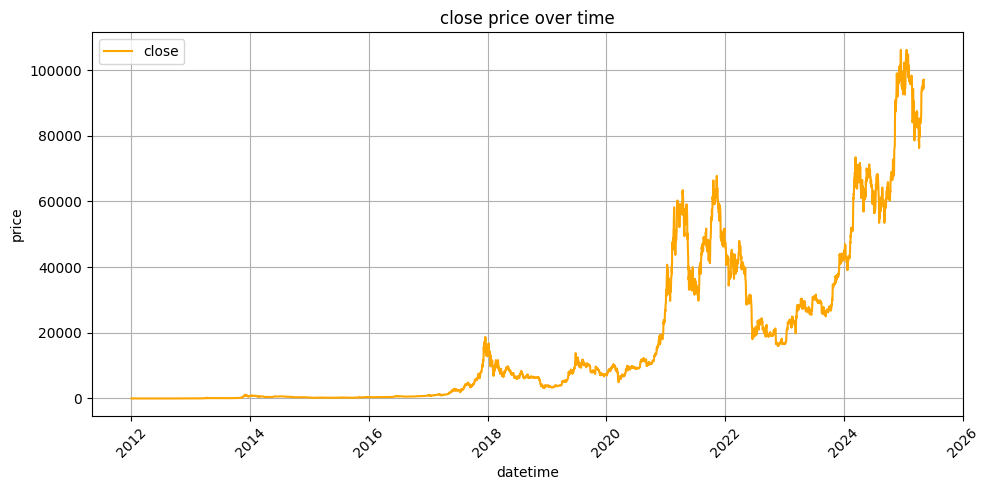

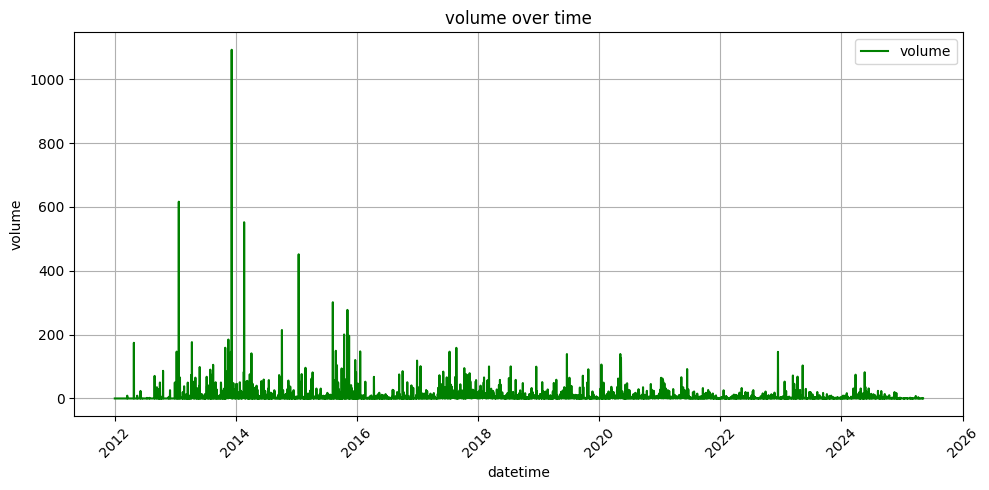

In [6]:
# Plot 1: Close price
plt.figure(figsize=(10, 5))
plt.plot(df['datetime'], df['Close'], label='close', color='orange')
plt.xlabel('datetime')
plt.ylabel('price')
plt.title('close price over time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Volume
plt.figure(figsize=(10, 5))
plt.plot(df['datetime'], df['Volume'], label='volume', color='green')
plt.xlabel('datetime')
plt.ylabel('volume')
plt.title('volume over time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Cell 4: Create tensor and define functions

In [7]:
tensor = torch.tensor(X_scaled, dtype=torch.float32)
close_idx = df.columns.get_loc('Close')
mean = scaler.mean_[close_idx]
std = scaler.scale_[close_idx]

def create_sequences(tensor, seq_length, target_idx):
  sequences = []
  targets = []

  for i in range(len(tensor) - seq_length):
    seq = tensor[i:i + seq_length]
    target_value =  tensor[i + seq_length, target_idx]
    sequences.append(seq)
    targets.append(target_value) 
  return torch.stack(sequences), torch.tensor(targets).unsqueeze(1)

seq_length = 60
batch_size = 64
dataset = TimeSeriesDataset(tensor, seq_length, close_idx)

train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3):
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
  mses = []
   
  if isinstance(num_epochs, list):
    for n in num_epochs:
      for epoch in range(n):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
          pred = model(batch_X)
          loss = loss_fn(pred.squeeze(), batch_y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
        model.eval()
        val_loss = 0
        with torch.no_grad():
          for val_X, val_y in val_loader:
            val_pred = model(val_X)
            val_loss += loss_fn(val_pred.squeeze(), val_y).item()
      mses.append(total_loss / len(train_loader)) 
  else:
    for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      for batch_X, batch_y in train_loader:
        pred = model(batch_X)
        loss = loss_fn(pred.squeeze(), batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
      model.eval()
      val_loss = 0
      with torch.no_grad():
        for val_X, val_y in val_loader:
          val_pred = model(val_X)
          val_loss += loss_fn(val_pred.squeeze(), val_y).item()
    mses.append(total_loss / len(train_loader)) 
  return mses 


#### Cell 5: RNN model training class

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim=1):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out

#### Cell 6: Training RNN Model + storing data into .pth file

In [9]:
rnn_model = RNNModel(input_dim=tensor.shape[1], hidden_dim=64)
epochs = [2, 4, 8, 16, 32, 64, 128]
print(f"number of epochs that gives the lowest MSE: {epochs[mses.index(min(mses))]}")

NameError: name 'mses' is not defined

#### Cell 7: To load trained RNN data

In [ ]:
rnn_model = RNNModel(input_dim=tensor.shape[1], hidden_dim=64)
rnn_model.load_state_dict(torch.load("rnn_model.pth"))

#### Cell 8: Recursive prediction method

In [ ]:
def predict_future(model, input_seq, steps, target_idx):
    model.eval()
    predictions = []
    seq = input_seq.clone()

    with torch.no_grad():
        for _ in range(steps):
            pred = model(seq.unsqueeze(0))
            pred_value = pred.item()
            predictions.append(pred_value * std + mean)

            # Create the next sequence by shifting and adding the prediction
            new_step = seq[-1].clone()
            new_step[target_idx] = pred_value  # Only update the target (Close price)
            seq = torch.cat((seq[1:], new_step.unsqueeze(0)), dim=0)

    return predictions

#### Cell 9: How many values we will predict with our trained model.

In [ ]:
last_seq = tensor[-seq_length:]  # Get the last sequence from the dataset
future_steps = 10  # our chosen number of predictions
normalized_predictions = predict_future(rnn_model, last_seq, steps=future_steps, target_idx=close_idx)
print(normalized_predictions)
print(set(normalized_predictions))

#### Cell 10: LSTM model training class

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim=1):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) 
    self.fc = nn.Linear(hidden_dim, 1)

  def forward(self, x): 
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

#### Cell 11: Training LSTM against dataset, then saving it in a `*.pth` file

In [ ]:
lstm_model = LSTMModel(input_dim = tensor.shape[1], hidden_dim=64)
mses = train_model(lstm_model, train_loader, val_loader, num_epochs=epochs)
torch.save(lstm_model.state_dict(), "lstm_model.pth")
print(f"number of epochs that gives the lowest MSE: {epochs[mses.index(min(mses))]}")

#### Loading trained LSTM Model data

In [ ]:
lstm_model = LSTMModel(input_dim=tensor.shape[1], hidden_dim=64)
lstm_model.load_state_dict(torch.load("lstm_model.pth"))

In [ ]:
last_seq = tensor[-seq_length:]  # Get the last sequence from the dataset
future_steps = 10  # our chosen number of predictions
predictions = predict_future(lstm_model, last_seq, steps=future_steps, target_idx=close_idx)
print(predictions)
print(set(predictions))

## Conclusion

After looking over the results from both models, we noticed that the LSTM's predictions tend to be more accurate than the RNN's. This is because it mitigates vanishing gradients between earlier and later layers in its architecture due to its gated structure, as well as it remembering long-term dependencies better than a vanilla RNN. However, this comes at the cost of taking longer to train. In our case, on an Nvidia 30-series consumer GPU, the difference was not that great. Additionally, the LSTM is not as easy to interpret, due to the complexity of its gate system.

Ultimately, either model could serve as a somewhat accurate predictor of the price of Bitcoin. RNNs predict semiconstant values or short periods of time correctly, while LSTMs can predict much longer patterns.